In [3]:
import numpy as np
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import re

In [4]:
def calculate_score(
    file_path,
    n,
    show_plots=True,
    save_dir=None,
    bins=50,
    kde=True,
    image_path=None,      # ← 추가: 이번 iter에 대응되는 이미지 경로
    image_title=None      # ← 타이틀(없으면 파일명)
):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    try:
        last_line = lines[n+1].strip()
        second_last_line = lines[n].strip()
    except Exception:
        print("done")
        return False

    def parse_line(line):
        parts = line.split(',')
        vals = []
        for val in parts:
            v = val.strip()
            if v.startswith('+'):
                v = v[1:]
            try:
                vals.append(float(v))
            except ValueError:
                continue
        return np.asarray(vals, dtype=float)

    values_last = parse_line(last_line)
    values_second_last = parse_line(second_last_line)
    if values_last.size == 0 or values_second_last.size == 0:
        raise ValueError("데이터를 읽지 못했습니다.")

    # ---- 3σ filter ----
    def filter_3sigma(values):
        m = np.mean(values)
        s = np.std(values, ddof=0)
        lower, upper = m - 3*s, m + 3*s
        return values[(values >= lower) & (values <= upper)], (m, s, (lower, upper))

    filtered_last, stats_last = filter_3sigma(values_last)
    filtered_second_last, stats_second = filter_3sigma(values_second_last)
    if filtered_last.size == 0 or filtered_second_last.size == 0:
        raise ValueError("3σ 이내 값이 없습니다.")

    avg_last  = float(np.mean(filtered_last))
    avg_second_last = float(np.mean(filtered_second_last))
    score = avg_last - avg_second_last

    # ---- helpers ----
    def gaussian_kde(x, grid):
        if x.size < 2:
            return np.zeros_like(grid)
        s = np.std(x, ddof=1)
        if s == 0:
            mu = np.mean(x)
            return np.exp(-0.5*((grid-mu)/1e-6)**2)/(np.sqrt(2*np.pi)*1e-6)
        h = 1.06 * s * (x.size ** (-1/5))
        h = max(h, 1e-6)
        u = (grid[:, None] - x[None, :]) / h
        kern = np.exp(-0.5 * u**2) / (np.sqrt(2*np.pi) * h)
        return np.mean(kern, axis=1)

    def load_gray_array(path: Path):
        """PIL로 읽어 '그레이스케일 ndarray'와 적절한 vmax 반환"""
        im = Image.open(path)
        # 이미 L(8bit) 또는 I;16(16bit)면 그대로, 아니면 흑백 변환
        if im.mode not in ("L", "I;16"):
            im = im.convert("L")
        arr = np.array(im)
        # dtype에 맞춰 vmin/vmax 고정 (자동 정규화 방지)
        if arr.dtype == np.uint8:
            vmin, vmax = 0, 255
        elif arr.dtype == np.uint16:
            vmin, vmax = 0, 65535
        else:
            # 그 외는 robust 범위
            lo, hi = np.percentile(arr, [0.5, 99.5])
            vmin, vmax = float(lo), float(hi)
        return arr, vmin, vmax

    # ---- figure: [이미지 | 히스토그램 | 히스토그램] ----
    fig, axes = plt.subplots(
        1, 3, figsize=(18, 5),
        gridspec_kw={"width_ratios": [1.2, 1, 1]}
    )

    # (0) 이미지
    if image_path is not None:
        arr, vmin, vmax = load_gray_array(Path(image_path))
        axes[0].imshow(arr, cmap="gray", vmin=vmin, vmax=vmax)
        axes[0].set_title(image_title or Path(image_path).name, fontsize=10)
        axes[0].axis("off")
    else:
        axes[0].axis("off")
        axes[0].set_title("No image")

    # (1)(2) 히스토그램: raw 분포 기준(평균/±3σ도 raw 기준)
    for ax, data, stats, title in zip(
        axes[1:],
        [values_last, values_second_last],
        [stats_last, stats_second],
        ["line profiles perpendicular to walls (3 sigma)",
         "line profiles parallel to walls (3 sigma)"]
    ):
        mean, std, (lo, up) = stats
        ax.hist(data, bins=bins, alpha=0.6, density=True, edgecolor="black")

        if kde and data.size >= 2:
            gmin, gmax = np.min(data), np.max(data)
            pad = 0.1 * (gmax - gmin + 1e-12)
            grid = np.linspace(gmin - pad, gmax + pad, 600)
            dens = gaussian_kde(data, grid)
            ax.plot(grid, dens, linewidth=2)

        ax.axvline(lo, linestyle="--", linewidth=2, label="-3σ")
        ax.axvline(up, linestyle="--", linewidth=2, label="+3σ")
        ax.axvline(mean, linestyle="-", linewidth=2, label="Mean")

        ax.set_title(title)
        ax.set_xlabel("Value")
        ax.set_ylabel("Density")
        ax.legend(loc="best")

    plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, f"n{n}_image_and_hists.png"), dpi=150, bbox_inches="tight")
    if show_plots:
        plt.show()
    else:
        plt.close(fig)

    extras = {
        "filtered_last_size": int(filtered_last.size),
        "filtered_second_last_size": int(filtered_second_last.size),
        "filtered_last_mean": avg_last,
        "filtered_second_last_mean": avg_second_last,
    }
    return score, avg_last, avg_second_last, extras


In [5]:
# ▼ INTENSITY 이미지 폴더
img_dir = Path(r"C:\bmes\Untitled Folder\2025-08-29")
exts = {".png", ".jpg", ".jpeg", ".bmp", ".tif", ".tiff"}

# "_0000000003_IMG_INTENSITY..." 또는 "_0000000003_INTENSITY..." 모두 매칭
seq_pat = re.compile(r"_(\d{6,})_(?:IMG_)?INTENSITY", re.IGNORECASE)

img_pairs = []
unmatched = []

# 하위 폴더까지 모두 탐색
for p in img_dir.rglob("*"):
    if p.is_file() and p.suffix.lower() in exts and "intensity" in p.name.lower():
        m = seq_pat.search(p.name)  # 확장자 포함 이름에서 검색해도 OK
        if m:
            img_pairs.append((int(m.group(1)), p))
        else:
            unmatched.append(p.name)

if not img_pairs:
    raise RuntimeError("INTENSITY 이미지에서 시퀀스 번호를 찾지 못했습니다. (정규식/경로 확인)")

# 디버그: 매칭 안 된 파일 이름 확인
if unmatched:
    print("[참고] 시퀀스 번호를 못 찾은 파일들:", unmatched[:10], "...")

# 시퀀스 번호 기준 정렬 및 iter 매핑 (가장 작은 번호 → iter 1)
img_pairs.sort(key=lambda t: t[0])
base_seq = img_pairs[0][0]
iter2path = {seq - base_seq + 1: path for (seq, path) in img_pairs}
max_iter = max(iter2path)

print(f"INTENSITY 이미지 {len(img_pairs)}개, 첫 시퀀스 {base_seq}, 마지막 iter {max_iter}")
# 앞 몇 개 확인
for k in range(1, min(5, max_iter) + 1):
    print(f"iter {k} -> {iter2path[k].name}")


INTENSITY 이미지 29개, 첫 시퀀스 3, 마지막 iter 29
iter 1 -> 250829_122814_0000000003_IMG_INTENSITY_OK.png
iter 2 -> 250829_123342_0000000004_IMG_INTENSITY_OK.png
iter 3 -> 250829_123850_0000000005_IMG_INTENSITY_OK.png
iter 4 -> 250829_124227_0000000006_IMG_INTENSITY_OK.png
iter 5 -> 250829_124854_0000000007_IMG_INTENSITY_OK.png


------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 1 : score : 5.702 (perpendicular profile mean : 24.893, parallel profile mean : 19.191)


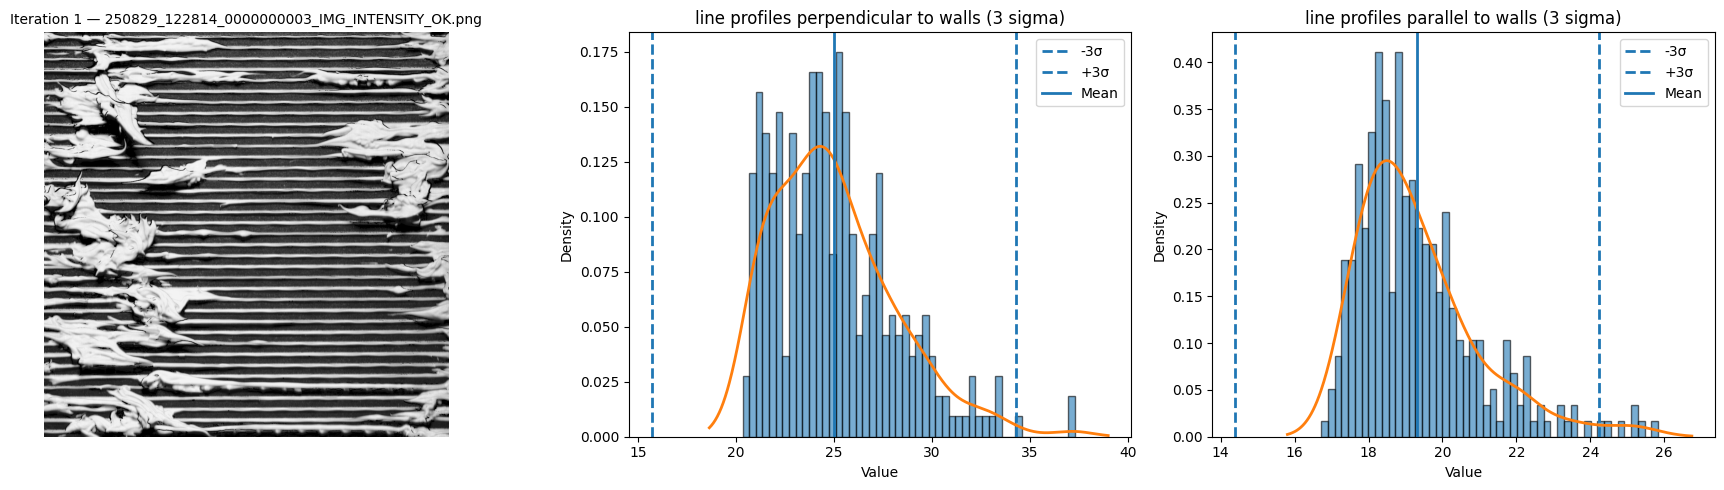

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 2 : score : 17.591 (perpendicular profile mean : 37.022, parallel profile mean : 19.432)


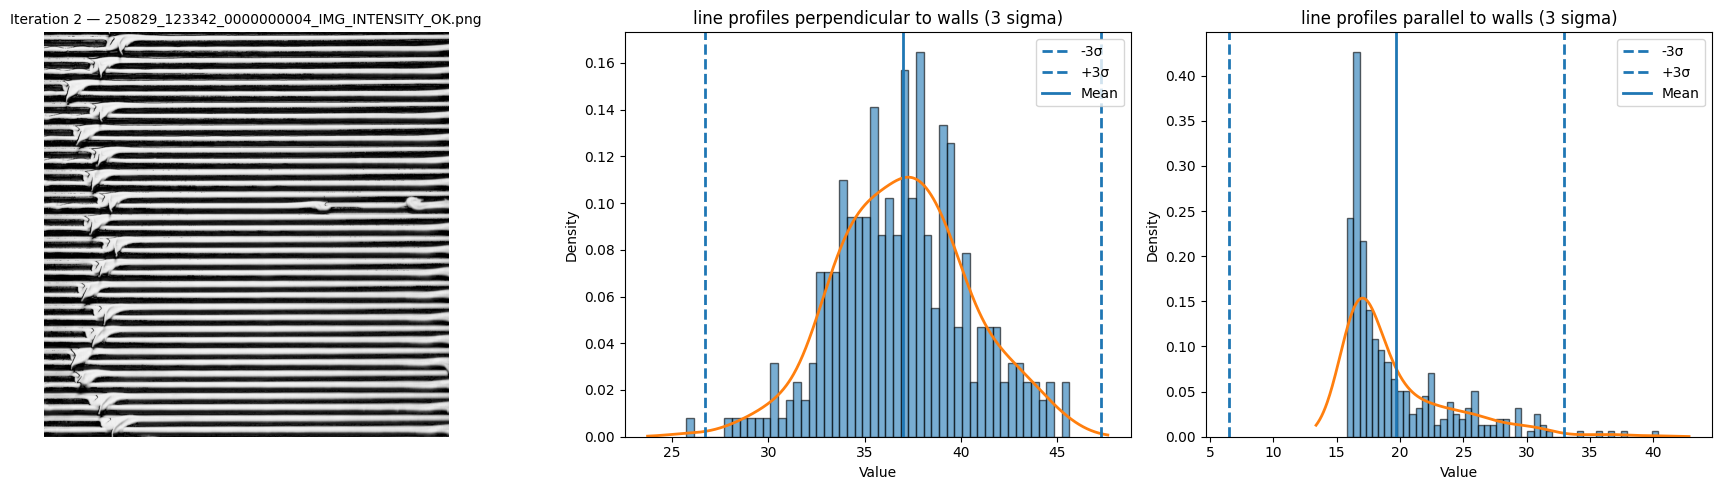

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 3 : score : 22.715 (perpendicular profile mean : 42.734, parallel profile mean : 20.019)


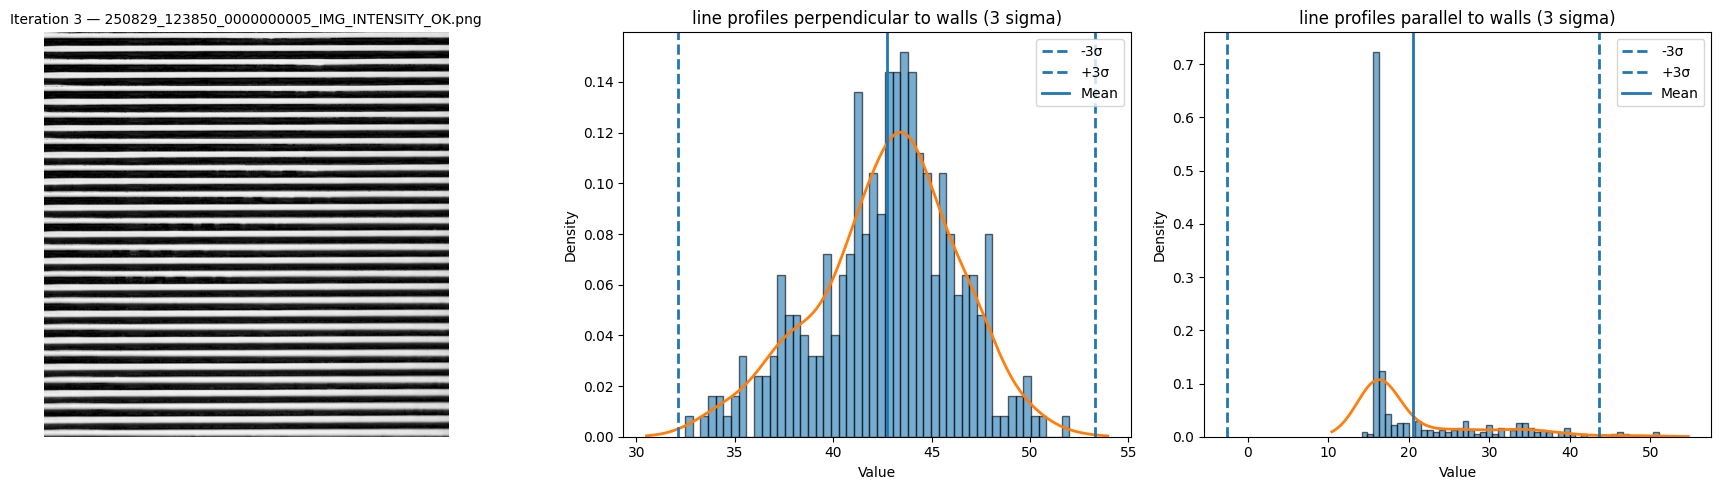

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 4 : score : 4.783 (perpendicular profile mean : 24.266, parallel profile mean : 19.482)


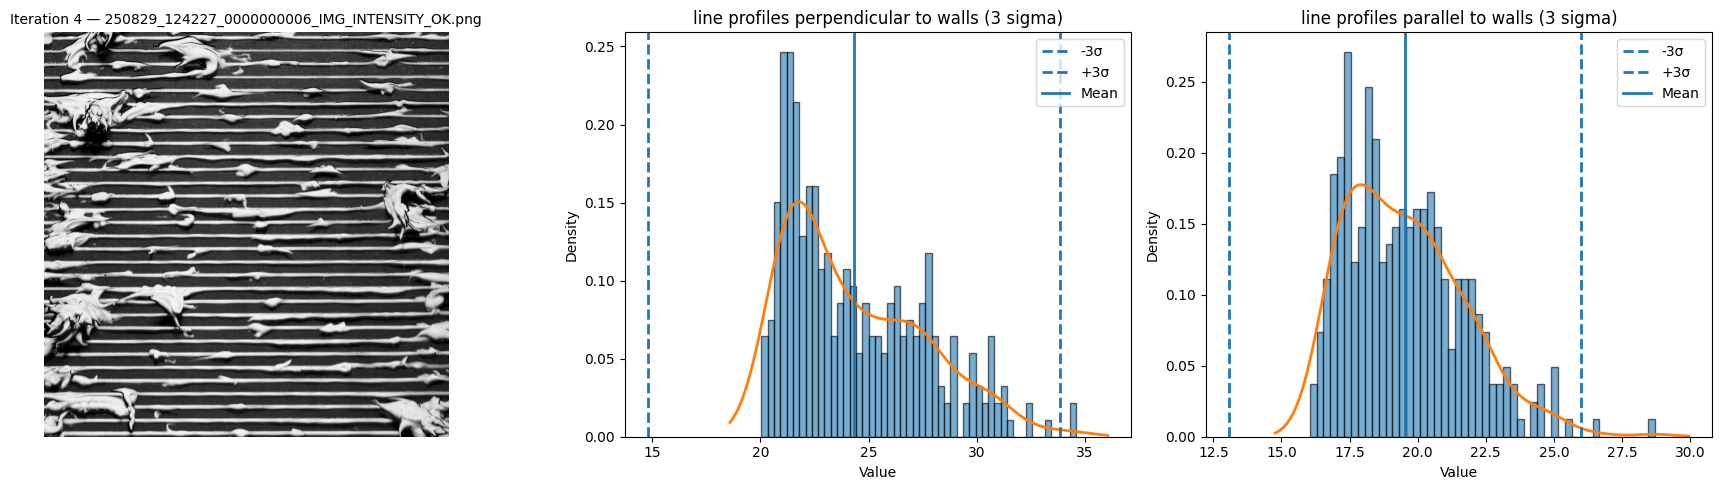

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 5 : score : 18.842 (perpendicular profile mean : 37.902, parallel profile mean : 19.059)


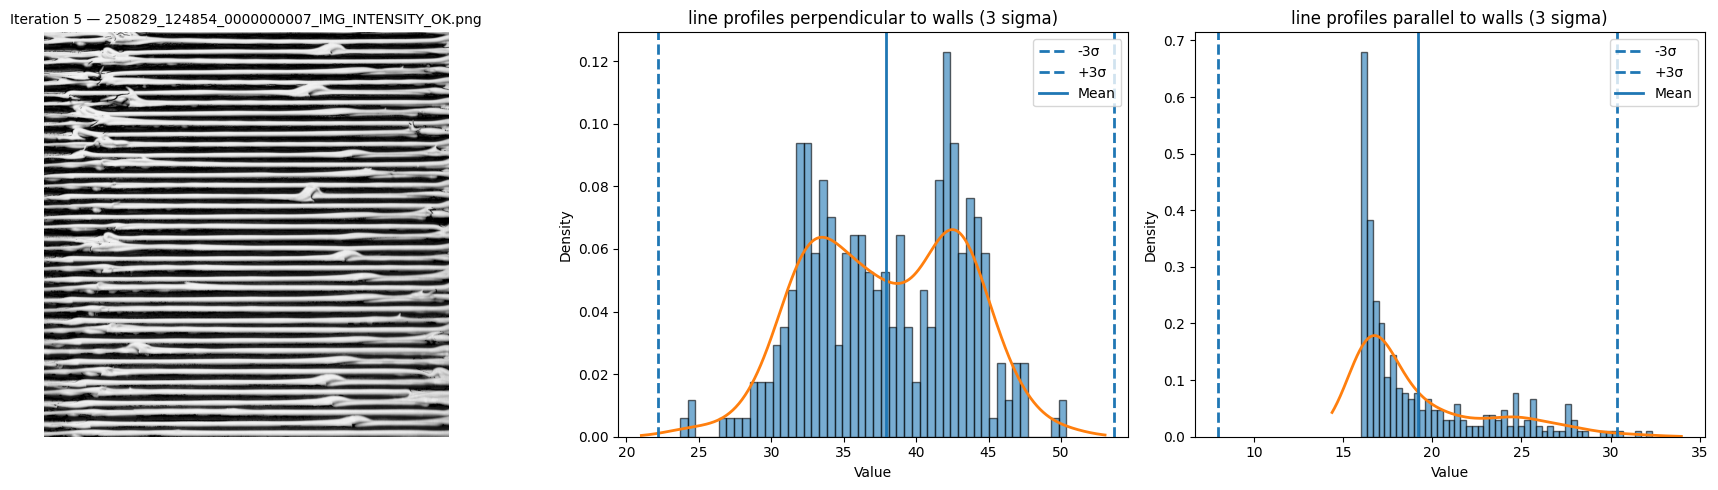

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 6 : score : 10.259 (perpendicular profile mean : 28.971, parallel profile mean : 18.712)


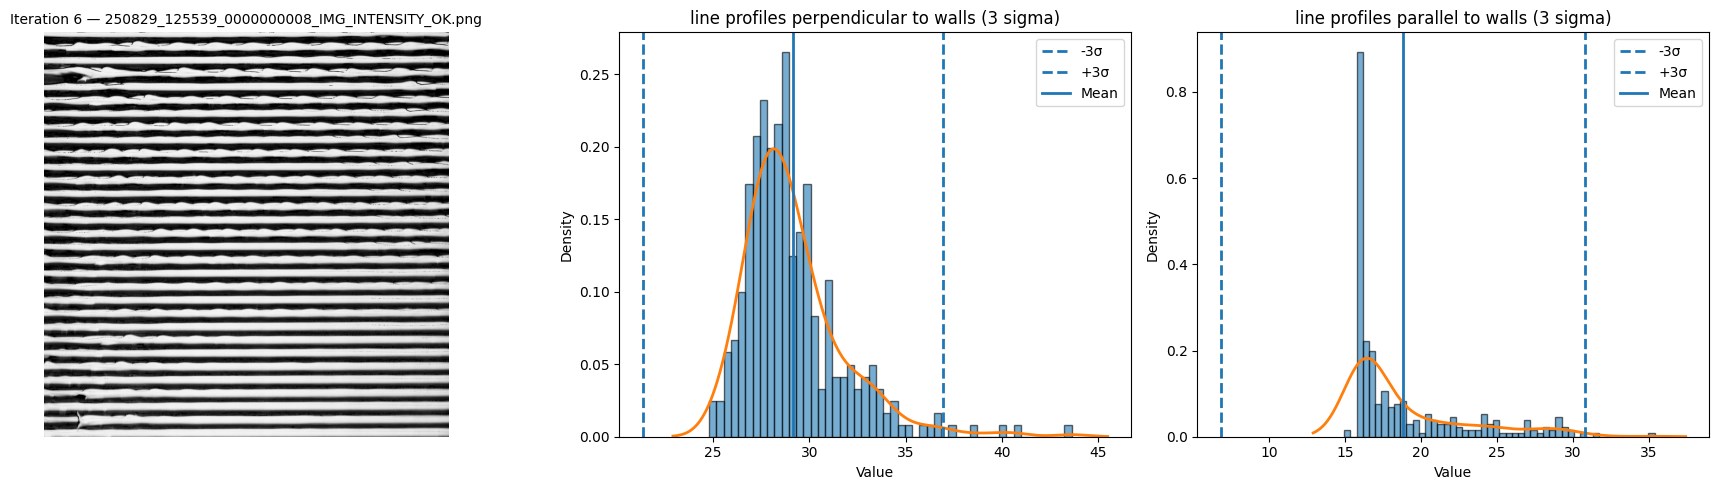

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 7 : score : 9.99 (perpendicular profile mean : 31.114, parallel profile mean : 21.124)


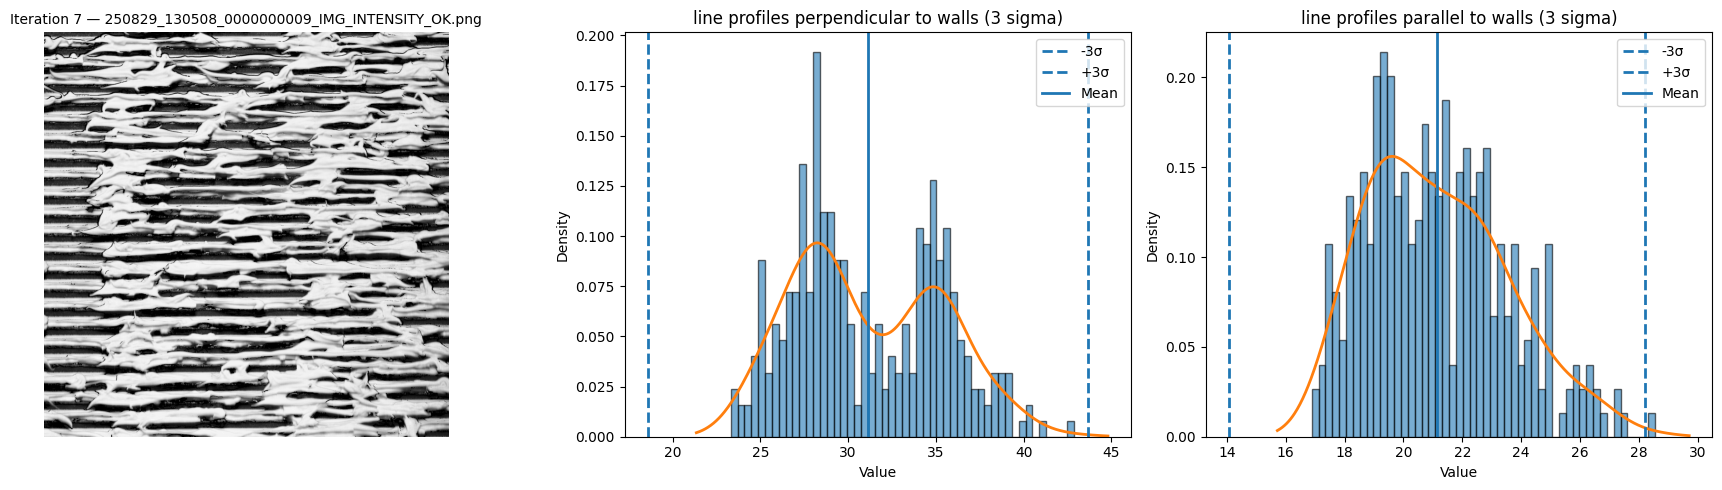

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 8 : score : 5.73 (perpendicular profile mean : 24.92, parallel profile mean : 19.19)


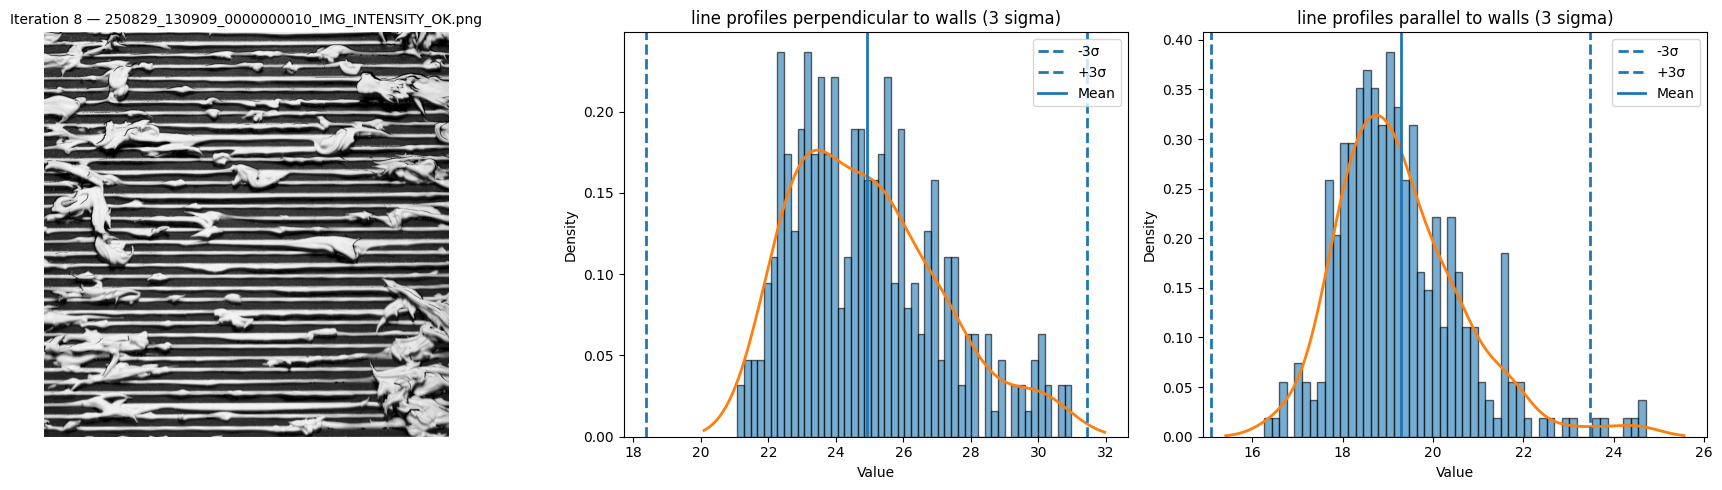

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 9 : score : 4.442 (perpendicular profile mean : 20.64, parallel profile mean : 16.198)


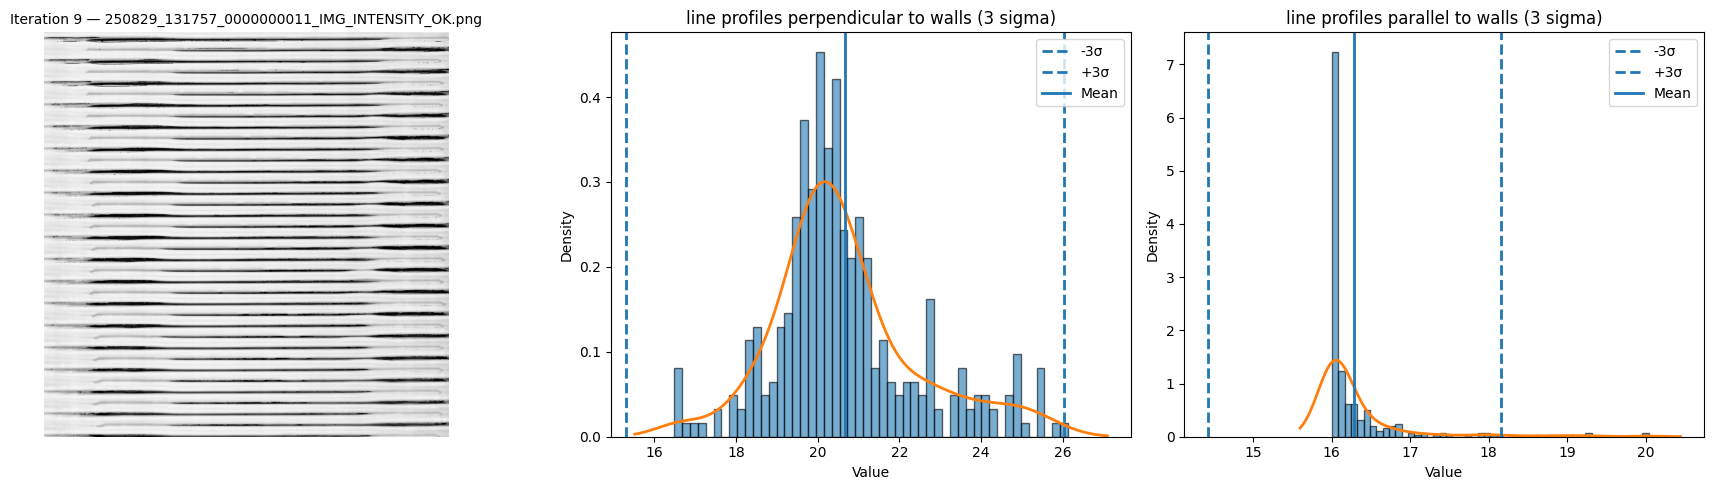

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 10 : score : 3.116 (perpendicular profile mean : 21.438, parallel profile mean : 18.322)


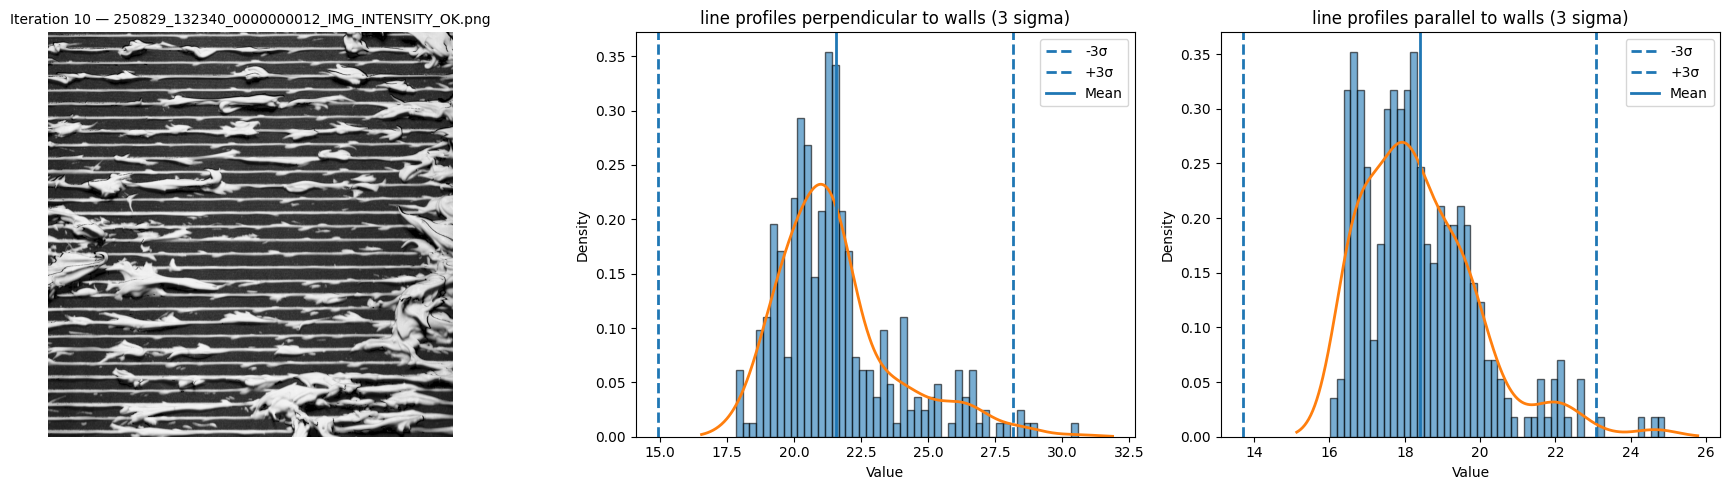

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 11 : score : 16.093 (perpendicular profile mean : 34.441, parallel profile mean : 18.348)


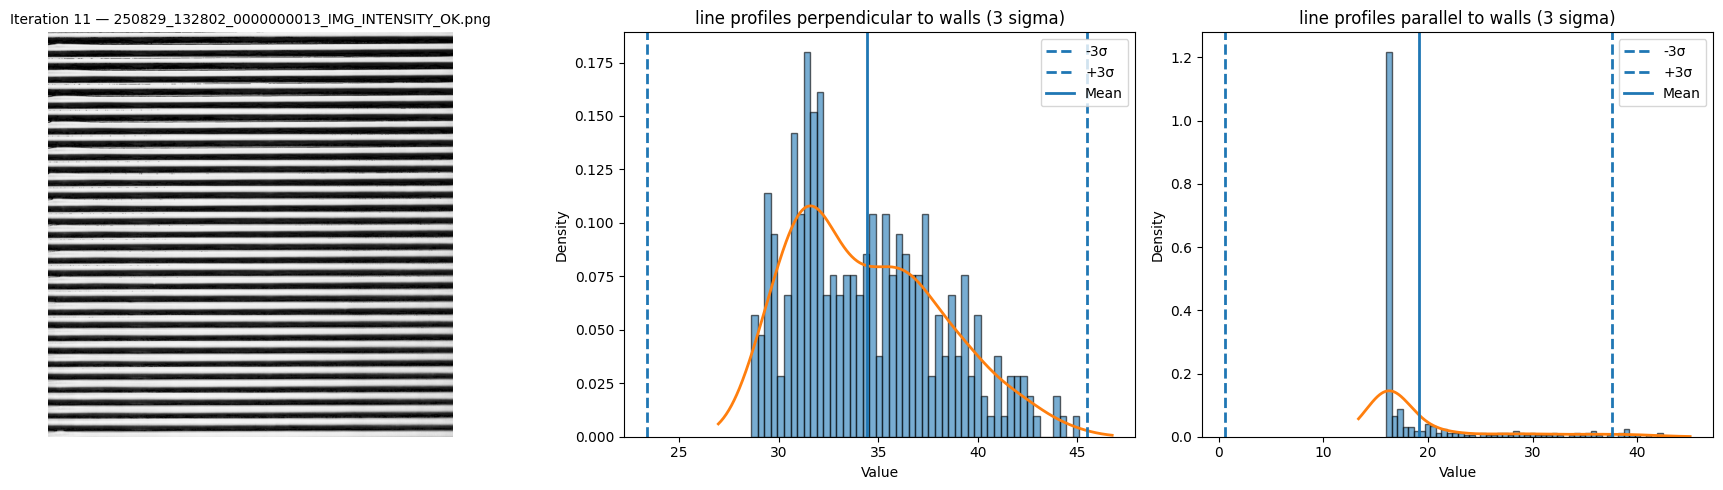

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 12 : score : 16.439 (perpendicular profile mean : 35.189, parallel profile mean : 18.751)


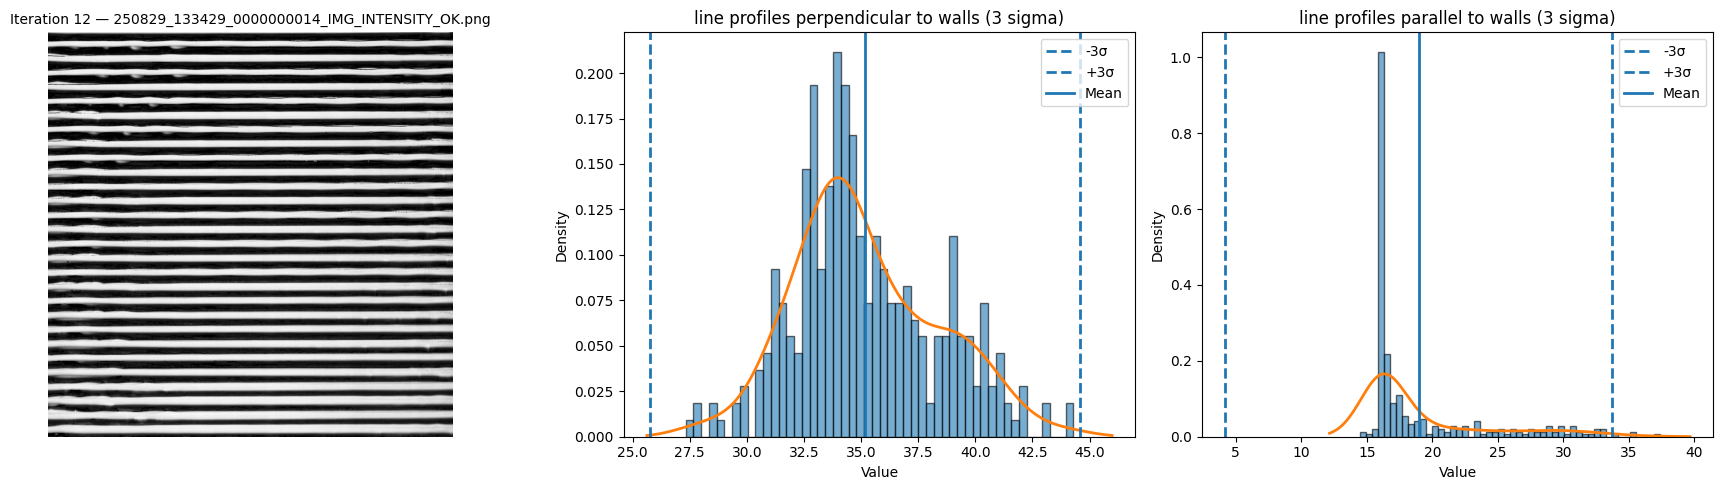

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 13 : score : 3.995 (perpendicular profile mean : 20.381, parallel profile mean : 16.386)


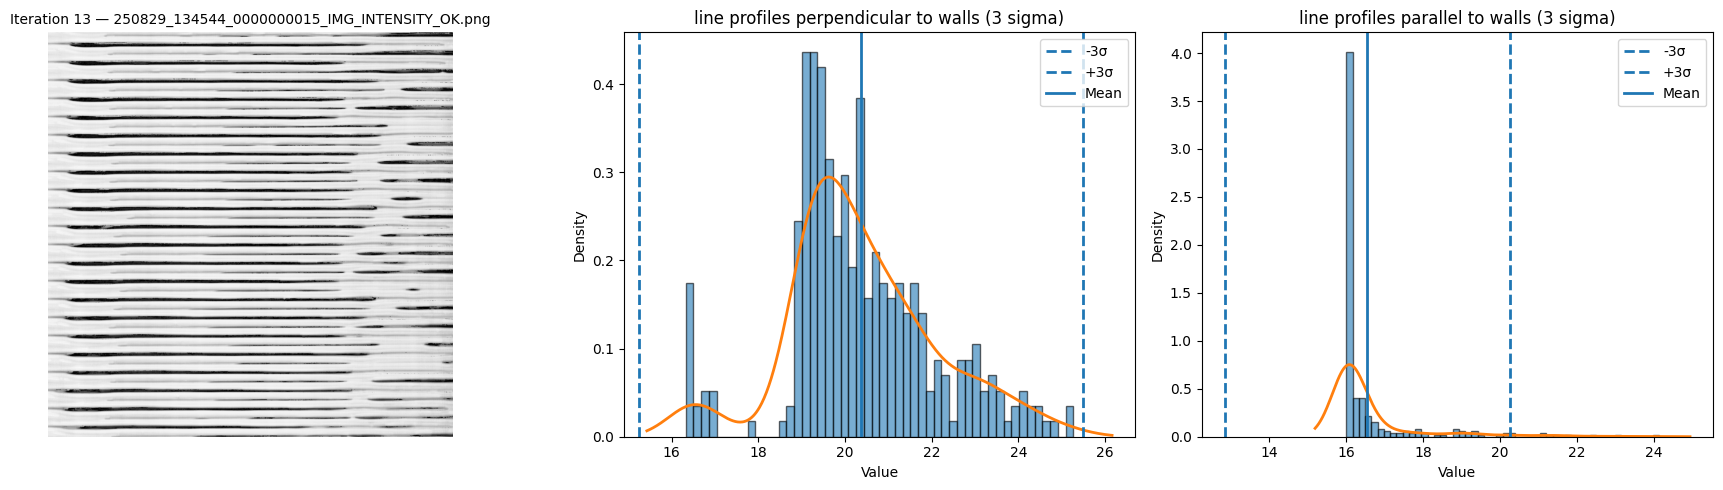

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 14 : score : 10.925 (perpendicular profile mean : 29.671, parallel profile mean : 18.746)


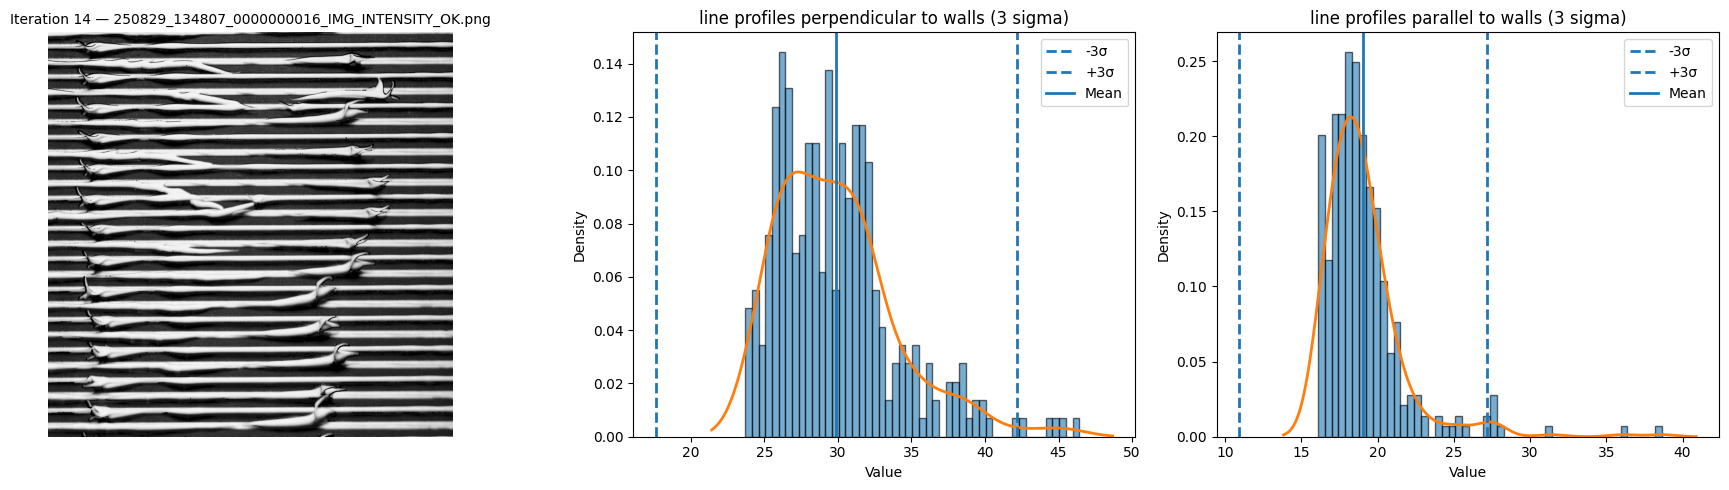

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 15 : score : 13.385 (perpendicular profile mean : 32.02, parallel profile mean : 18.635)


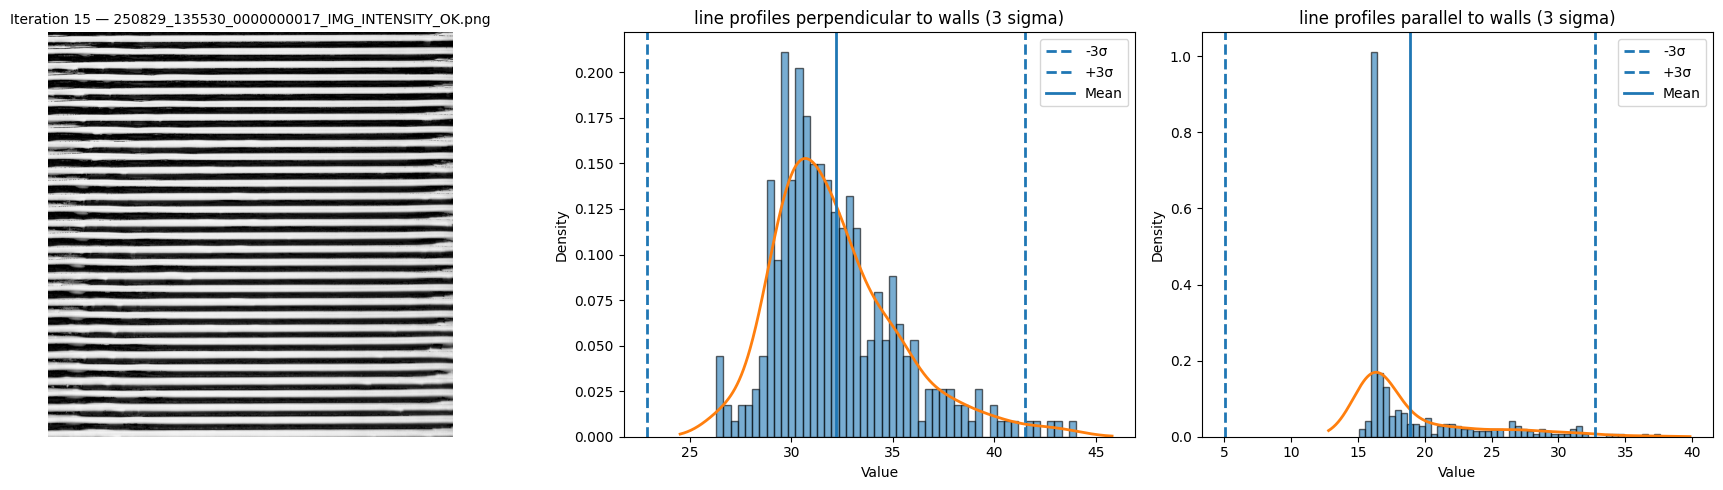

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 16 : score : 14.15 (perpendicular profile mean : 32.803, parallel profile mean : 18.653)


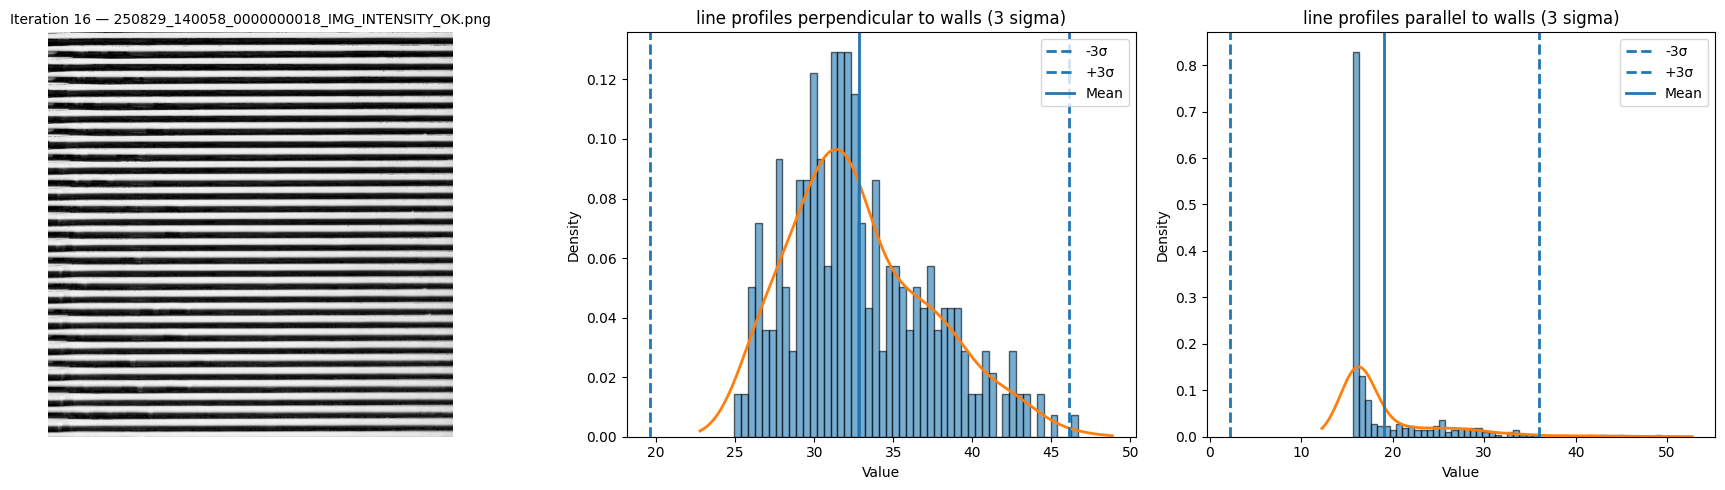

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 17 : score : 22.577 (perpendicular profile mean : 42.029, parallel profile mean : 19.452)


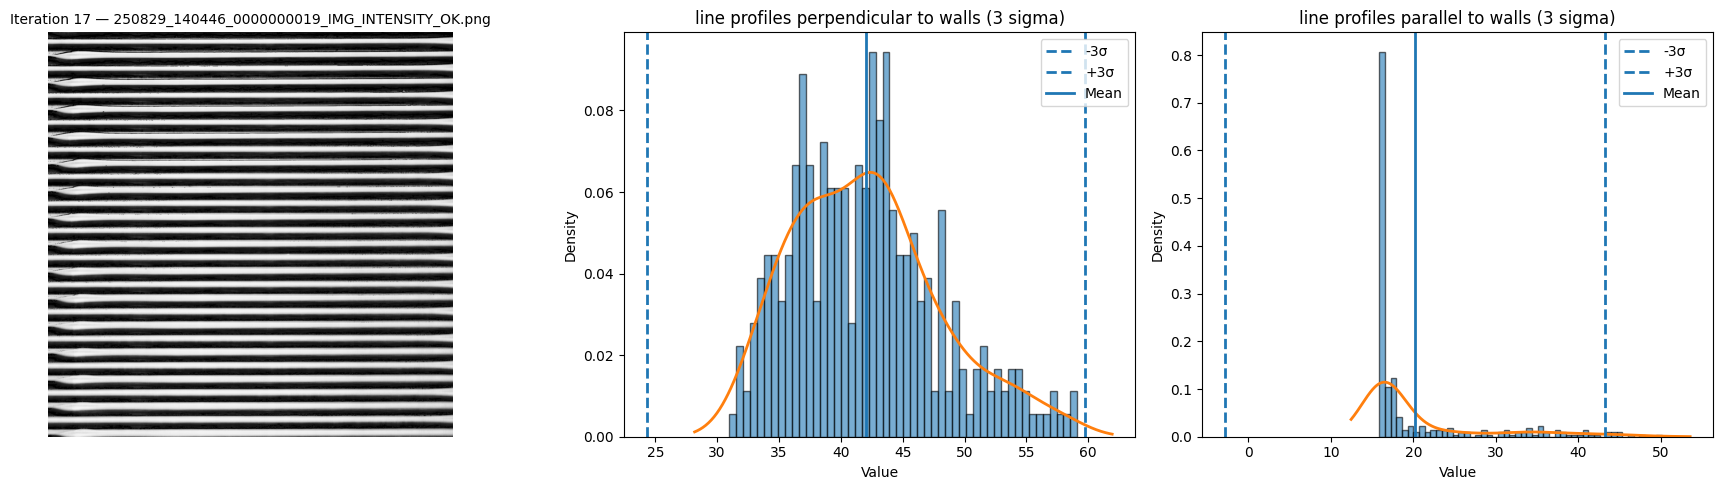

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 18 : score : 8.088 (perpendicular profile mean : 25.516, parallel profile mean : 17.428)


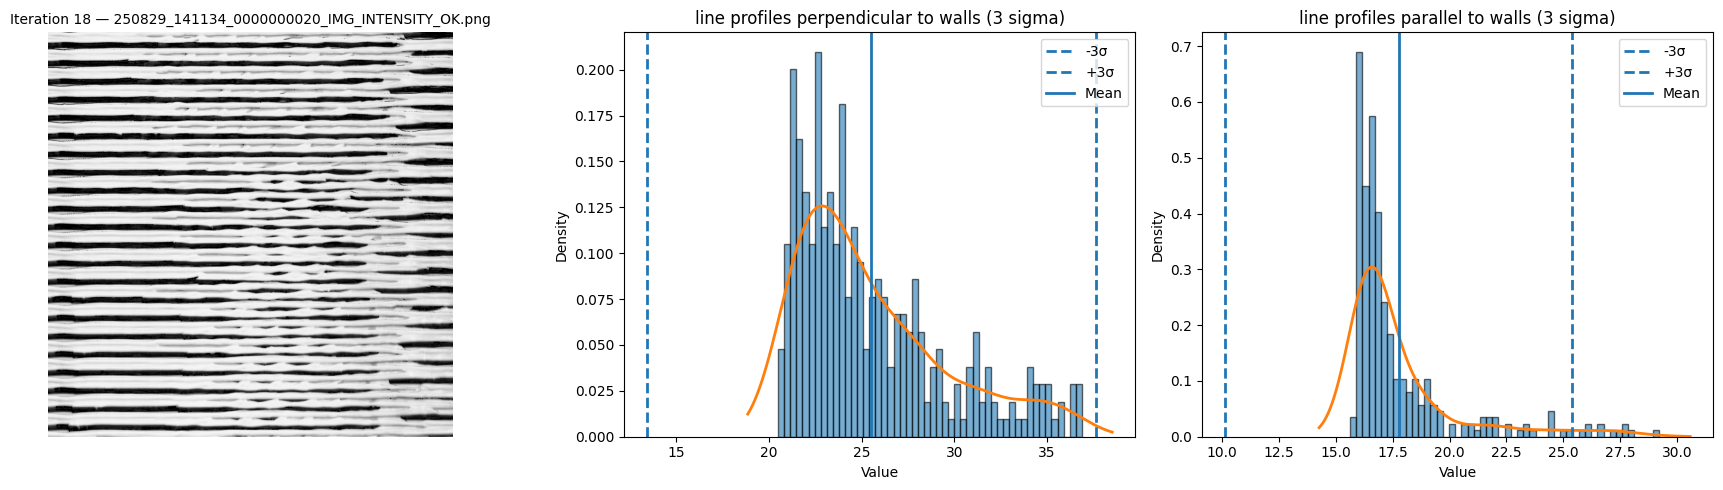

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 19 : score : 29.645 (perpendicular profile mean : 50.295, parallel profile mean : 20.65)


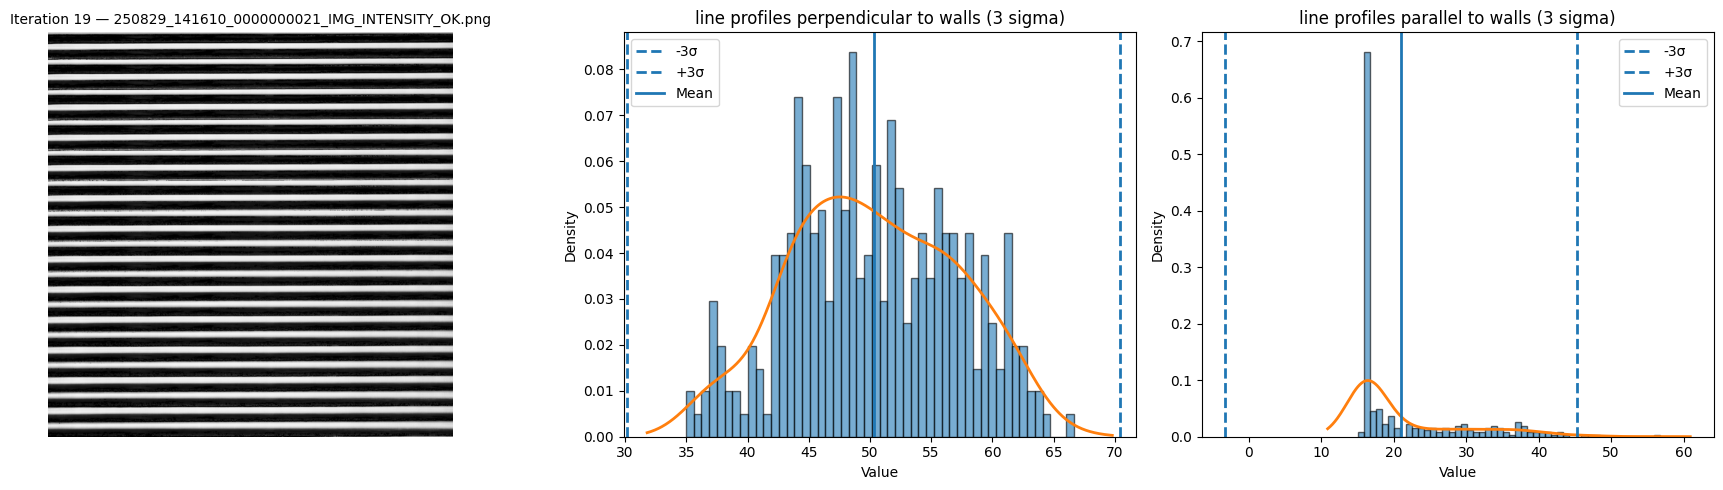

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 20 : score : 21.327 (perpendicular profile mean : 39.427, parallel profile mean : 18.1)


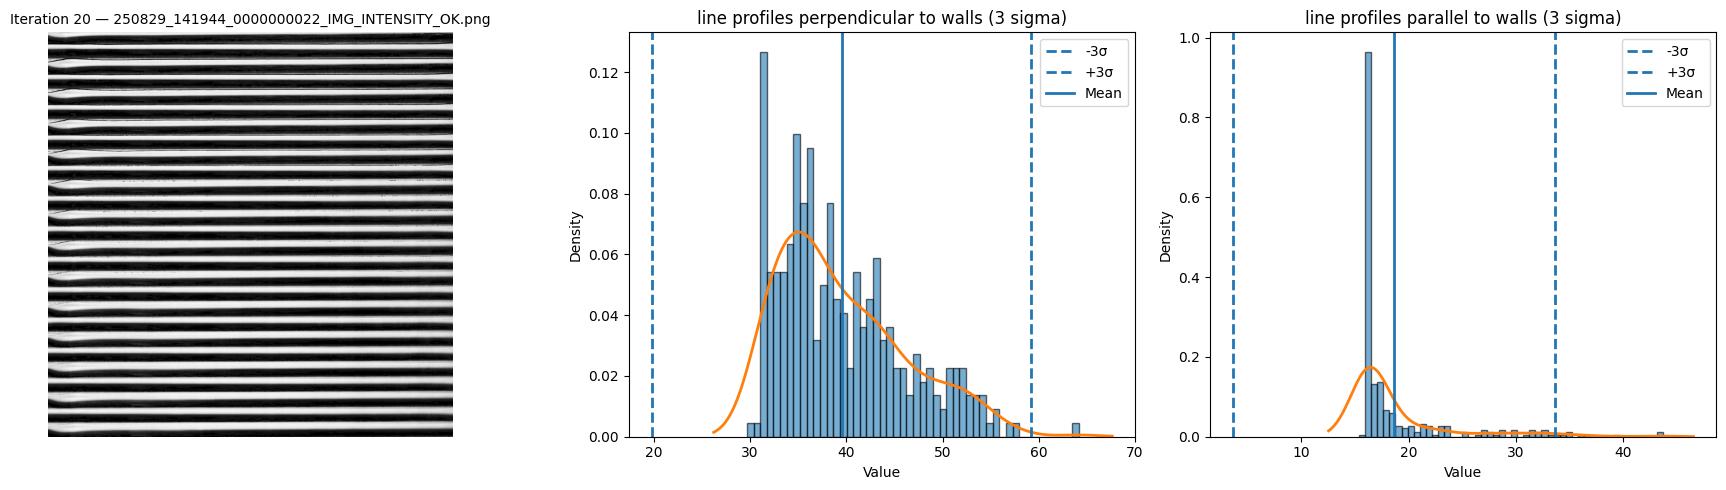

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 21 : score : 10.577 (perpendicular profile mean : 29.06, parallel profile mean : 18.482)


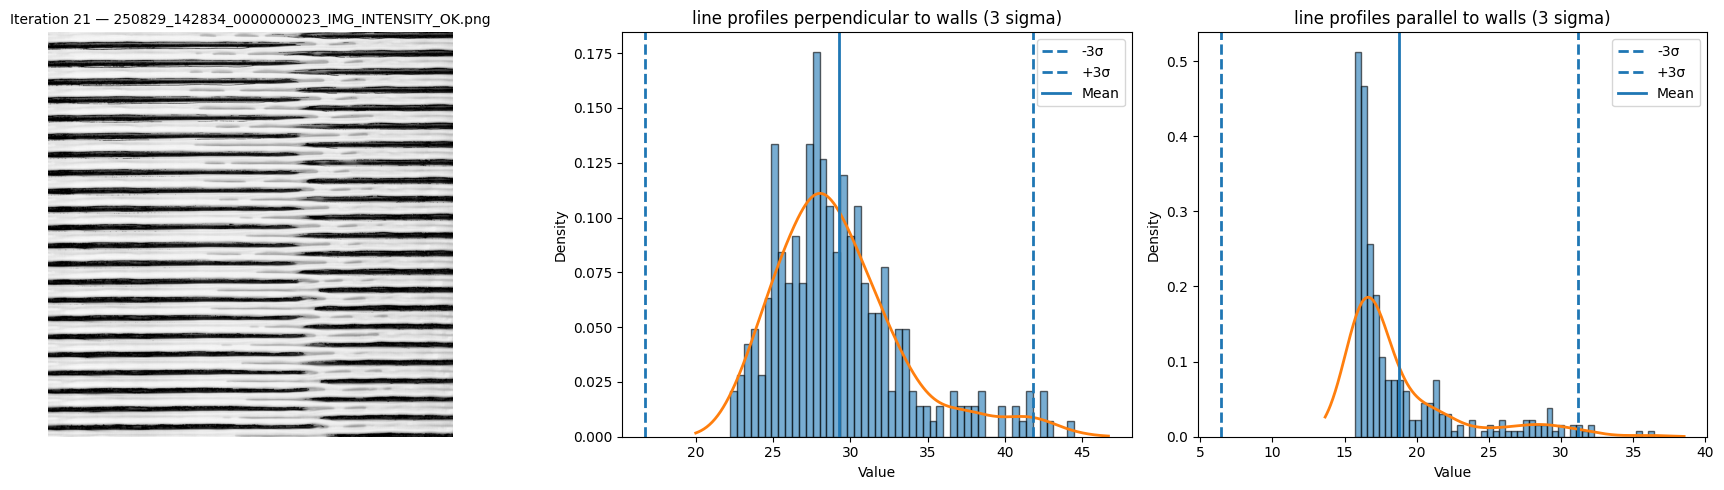

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 22 : score : 30.854 (perpendicular profile mean : 51.215, parallel profile mean : 20.361)


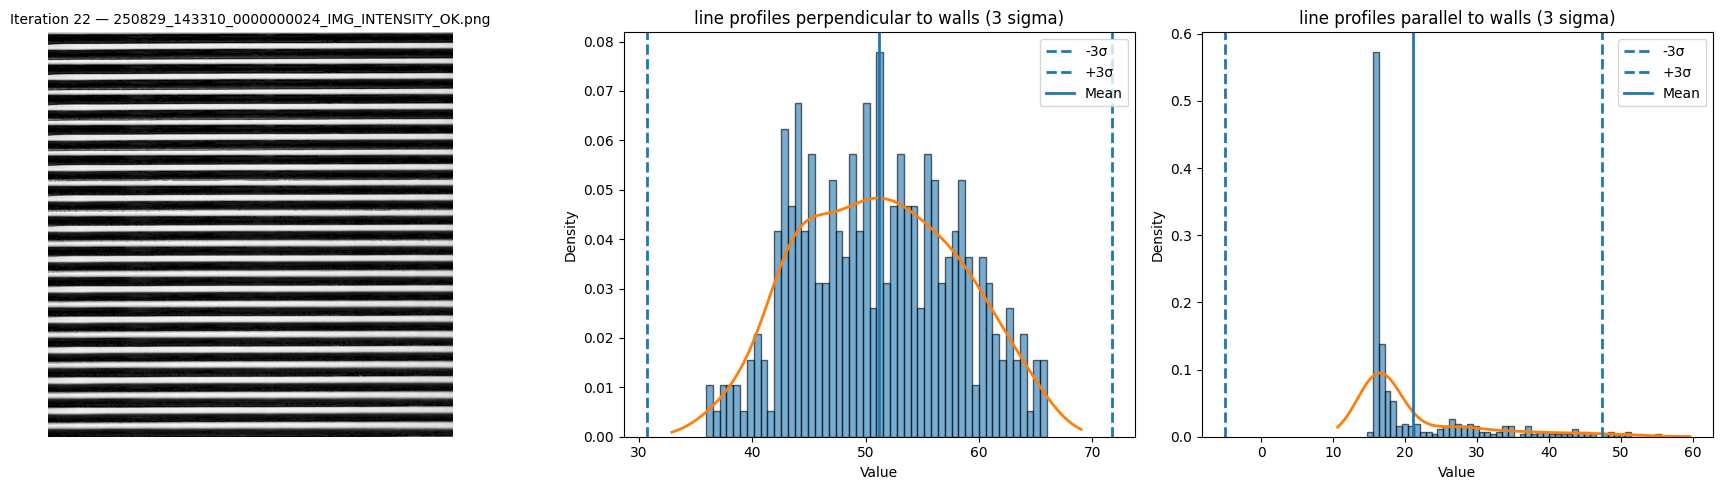

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 23 : score : 28.729 (perpendicular profile mean : 48.343, parallel profile mean : 19.615)


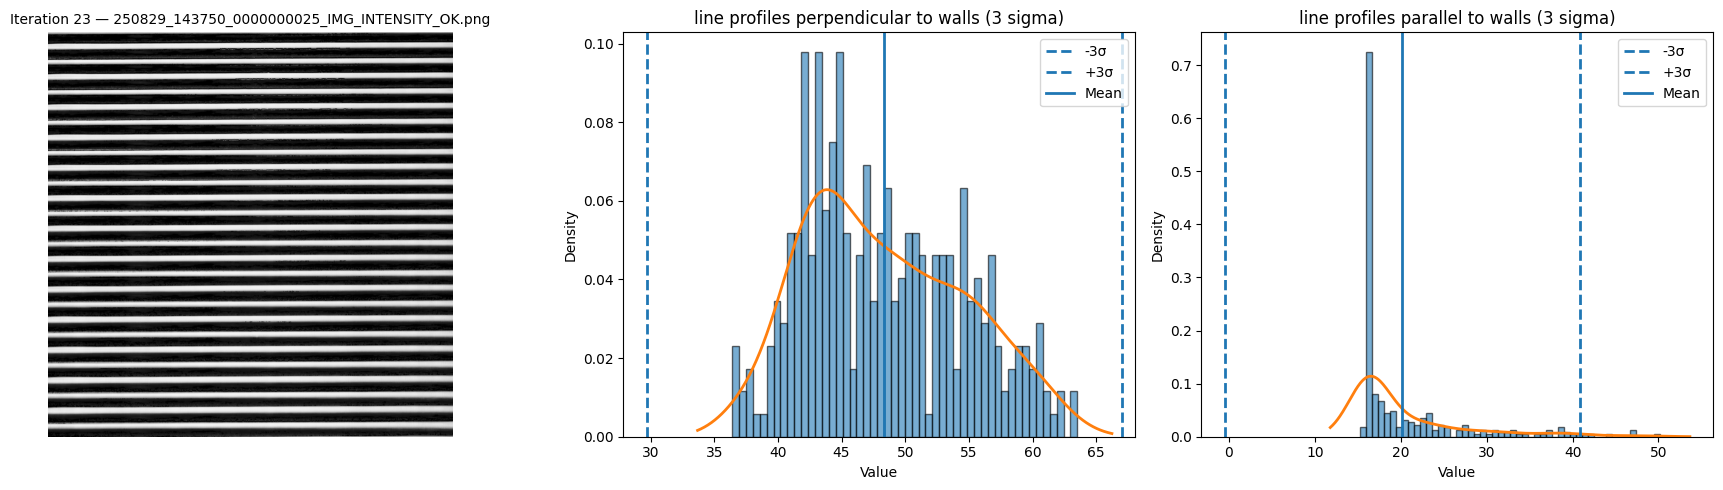

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 24 : score : 17.003 (perpendicular profile mean : 37.263, parallel profile mean : 20.26)


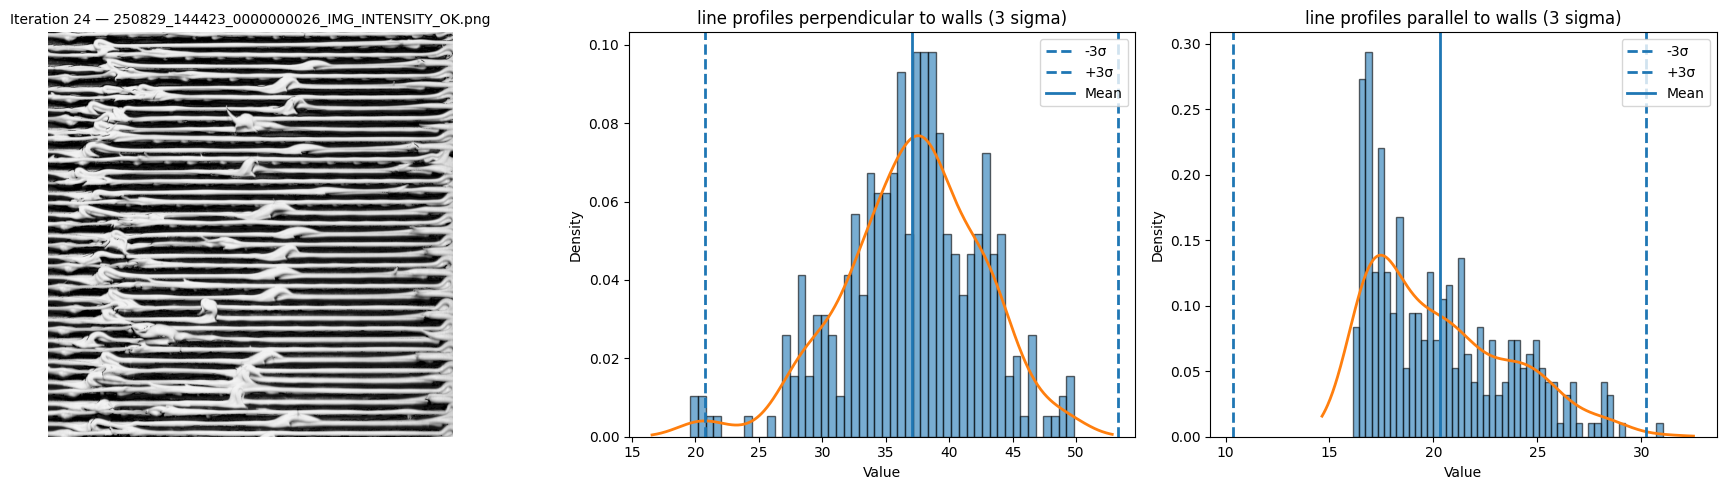

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 25 : score : 10.077 (perpendicular profile mean : 30.711, parallel profile mean : 20.634)


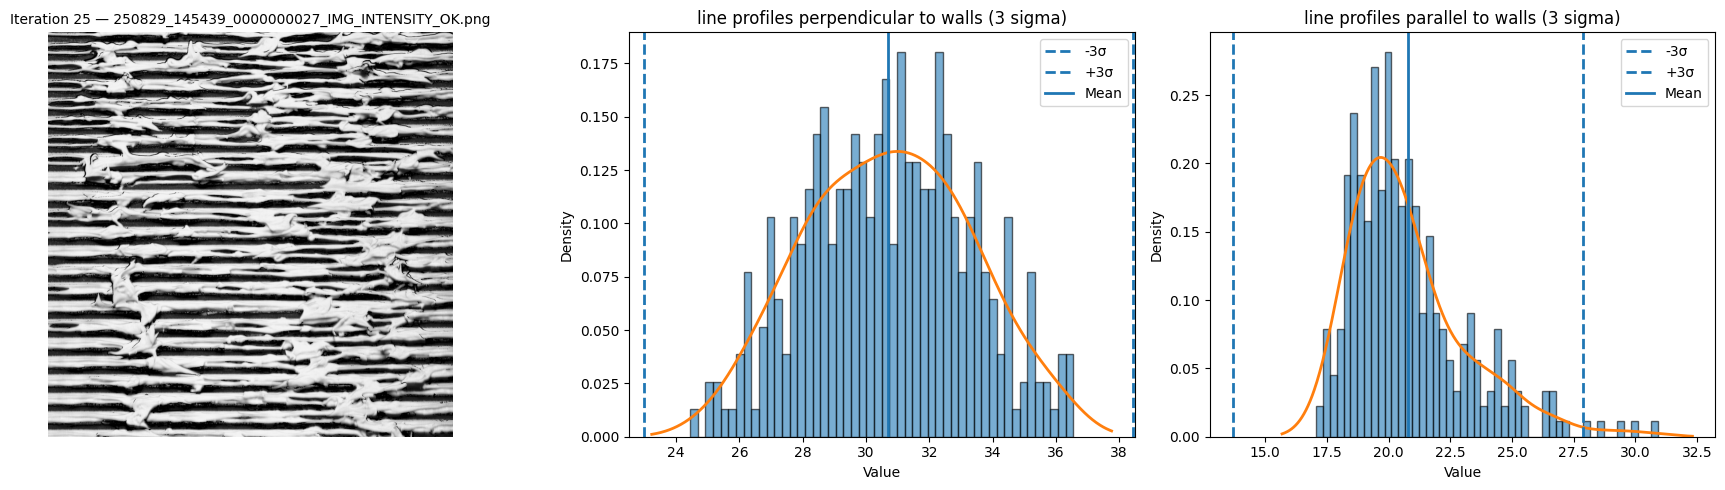

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 26 : score : 4.362 (perpendicular profile mean : 21.585, parallel profile mean : 17.223)


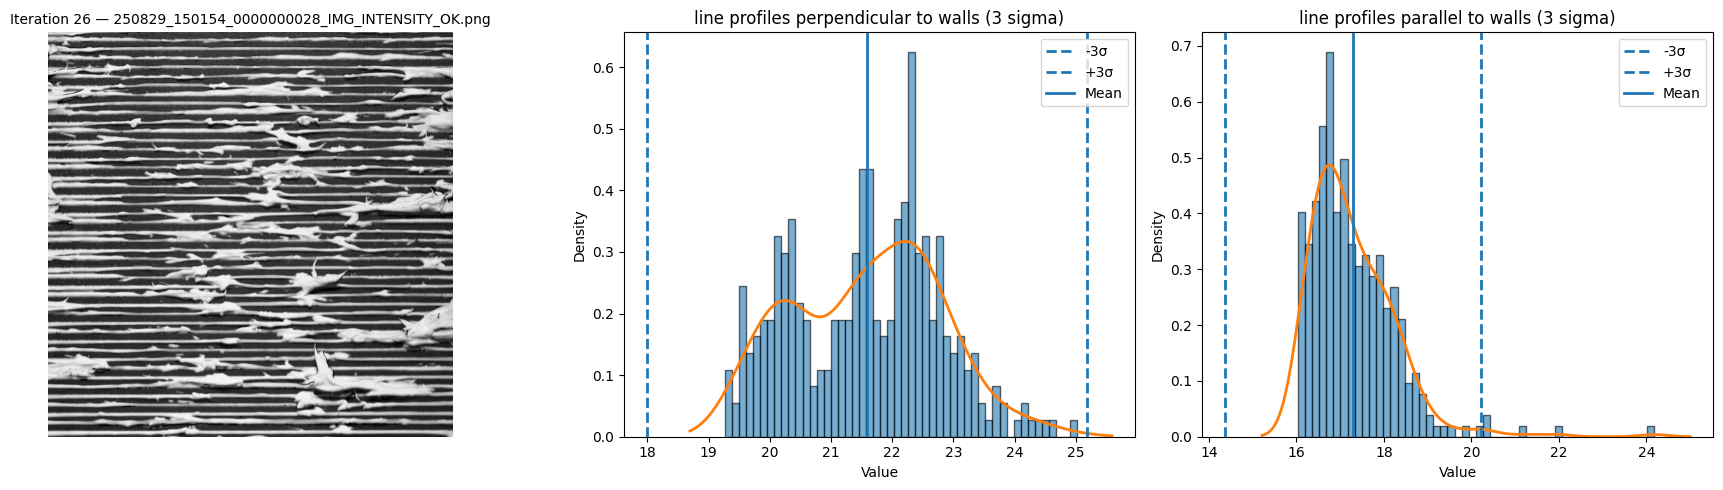

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 27 : score : 0.096 (perpendicular profile mean : 16.199, parallel profile mean : 16.103)


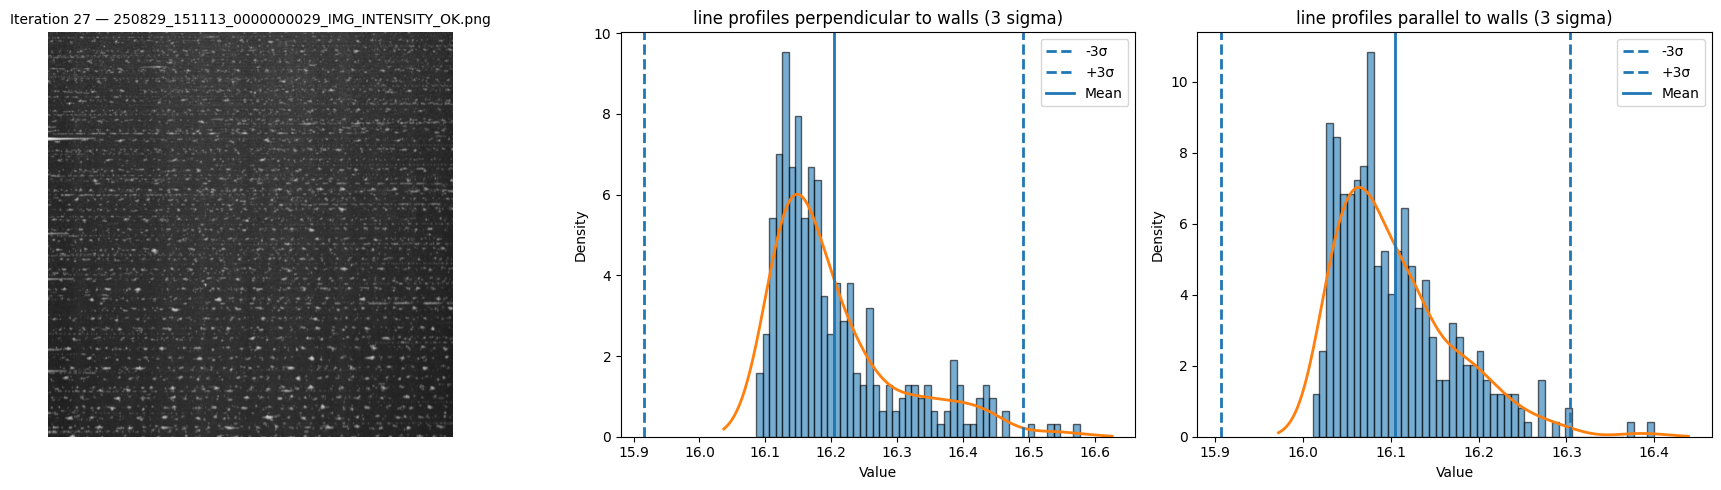

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 28 : score : 2.897 (perpendicular profile mean : 22.837, parallel profile mean : 19.94)


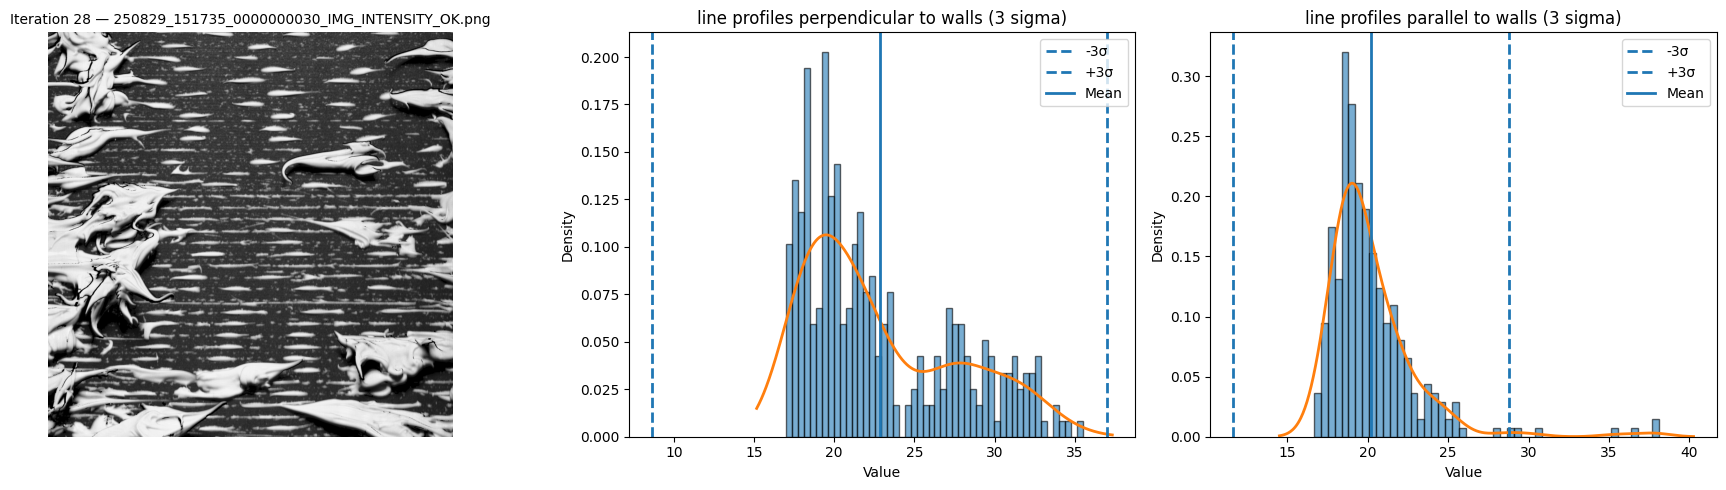

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 29 : score : 0.093 (perpendicular profile mean : 16.121, parallel profile mean : 16.027)


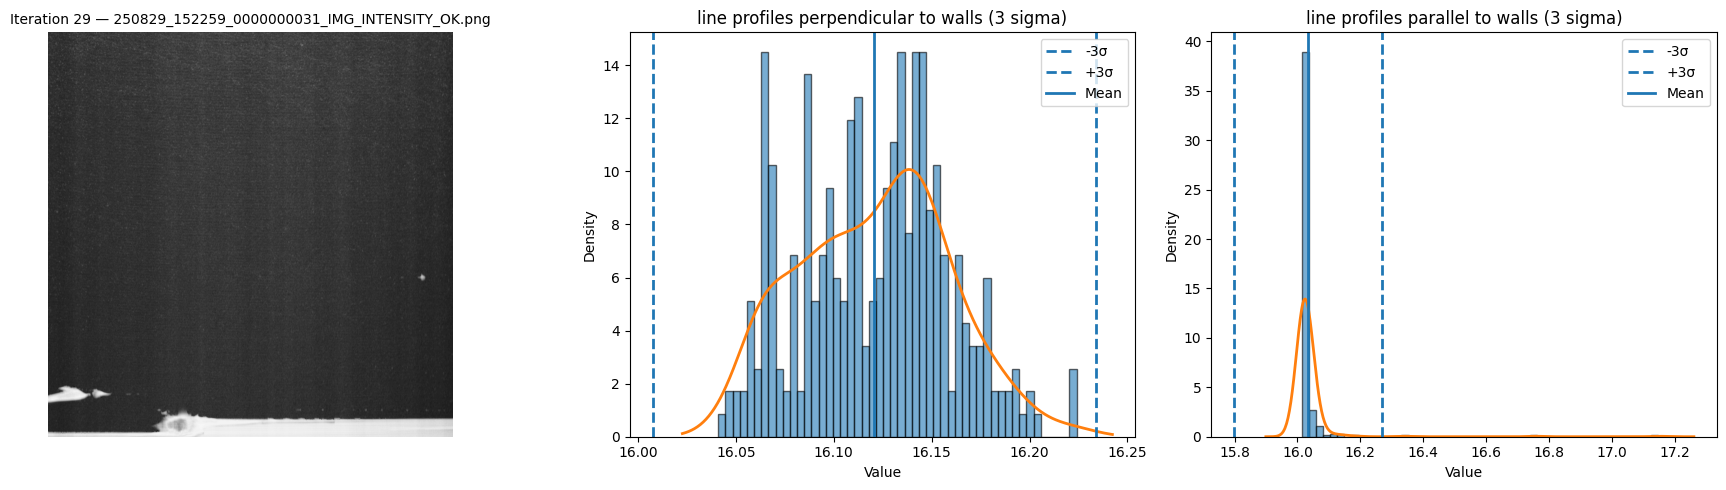

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 30 : score : 0.0 (perpendicular profile mean : 0.0, parallel profile mean : 0.0)


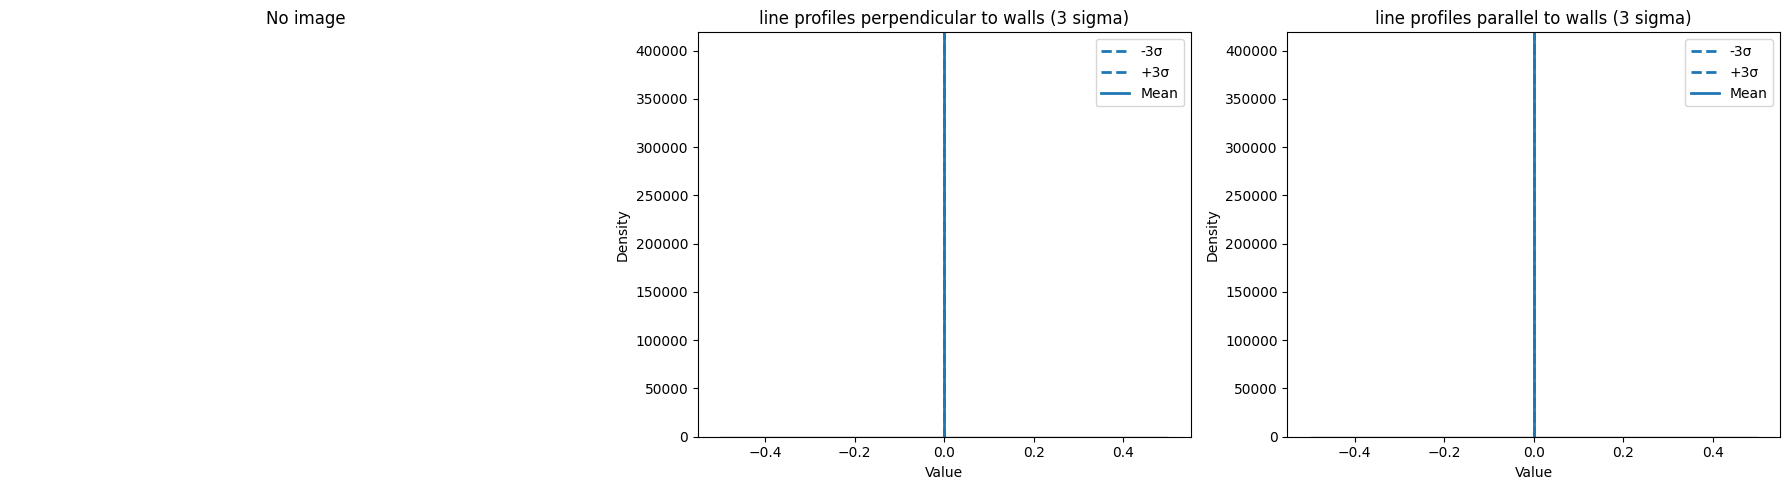

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 31 : score : 0.0 (perpendicular profile mean : 0.0, parallel profile mean : 0.0)


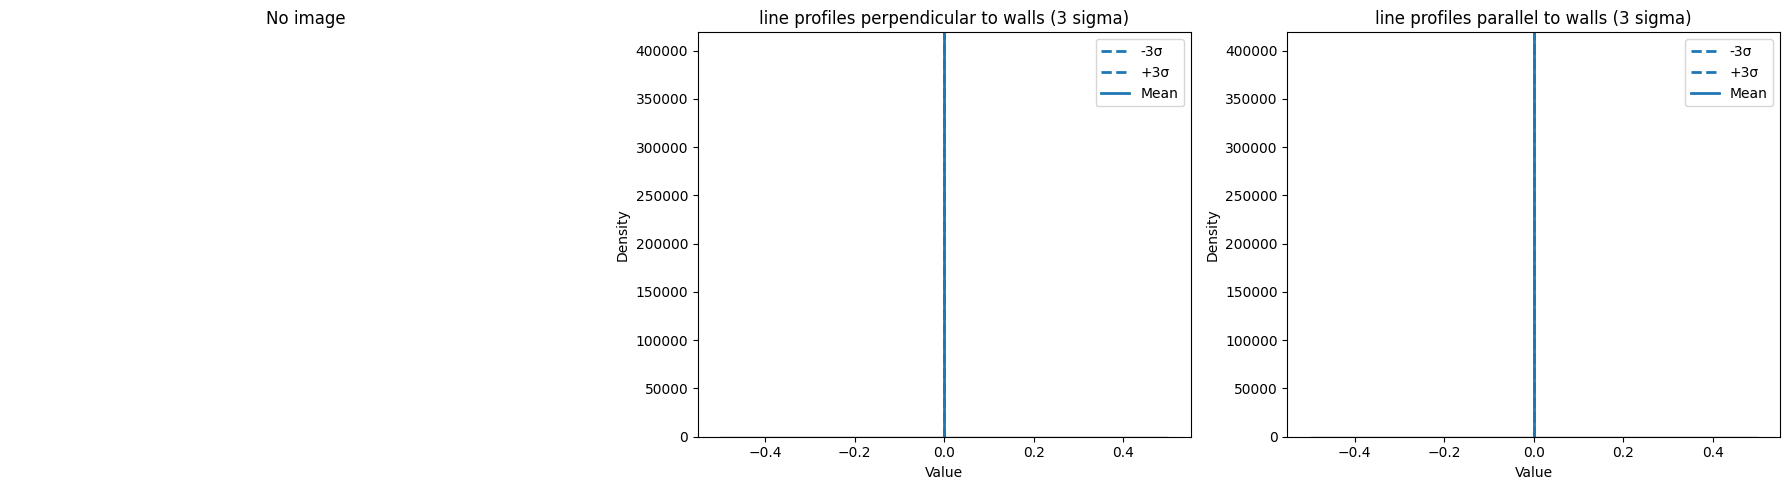

------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------
iter 32 : score : 10.011 (perpendicular profile mean : 28.357, parallel profile mean : 18.347)


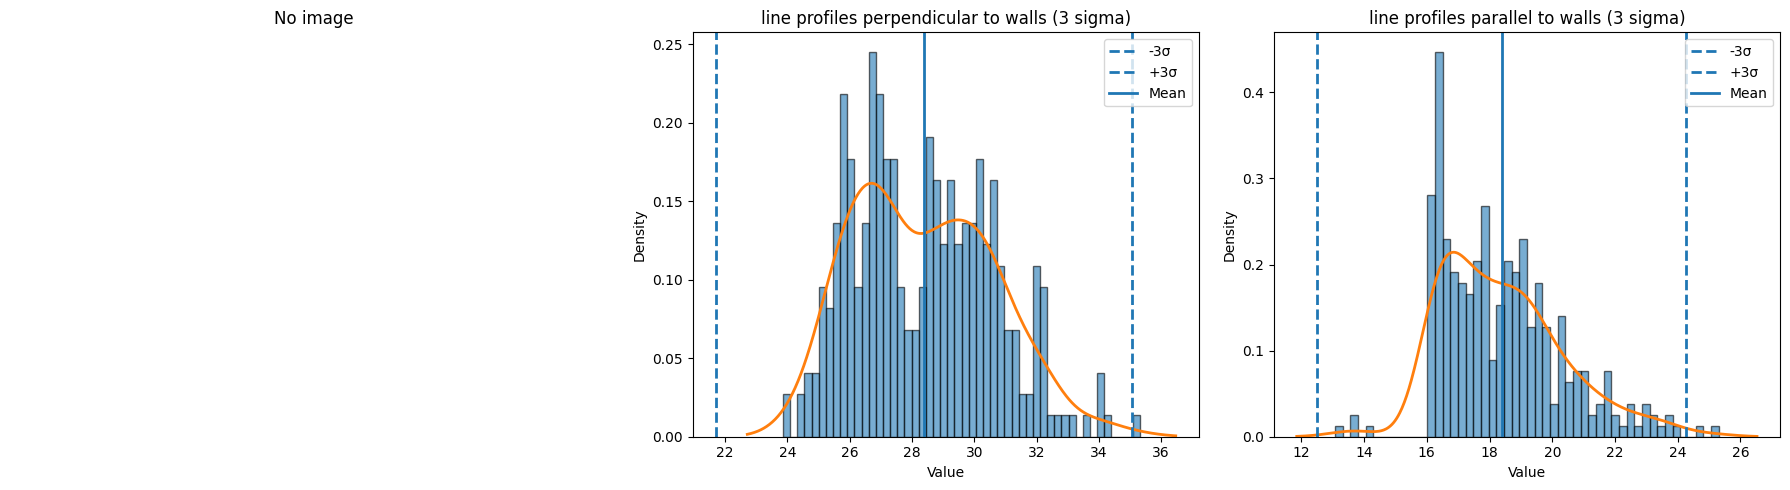

done
done


In [10]:
file = r"C:\Users\jonghyun\Downloads\250829_104449.txt"

boStart = False
count = 0
iter = 1

while True:
    # 1) 먼저 계산만 (출력/그림 없음)
    res = calculate_score(file, count, show_plots=False)
    if res is False:
        print("done")
        break
    score, avg_last, avg_second_last, extras = res

    # 2) 트리거 체크 (이번 쌍에서 켜짐)
    if not boStart and round(score, 3) == 5.702:
        boStart = True

    # 3) 시작 이후엔: print 먼저, 그 다음 같은 iter/count로 그림 렌더
    if boStart:
        
        print("-"*138)
        print("-"*138)
        
        print(
            f"iter {iter} : score : {round(score, 3)} "
            f"(perpendicular profile mean : {round(avg_last, 3)}, "
            f"parallel profile mean : {round(avg_second_last, 3)})",
            flush=True
        )
        
        

        img_path = iter2path.get(iter)  # 시퀀스→iter 매핑 딕셔너리 (앞서 만든 것)
        calculate_score(
            file, count,
            show_plots=True,                 # 여기서만 그림 출력
            image_path=img_path,
            image_title=f"Iteration {iter} — {img_path.name}" if img_path else None
        )

        iter += 1

    # 4) 다음 줄 쌍으로 이동
    count += 2


In [13]:
!pwd 
!git init -b main
!git config user.name "hguhcbuf"
!git config user.email "15edwink@gmail.com"


/c/bmes/Untitled Folder
Reinitialized existing Git repository in C:/bmes/Untitled Folder/.git/


In [14]:
gitignore = r"""
# Python
__pycache__/
*.pyc
*.pyo
*.pyd
*.egg-info/

# Jupyter
.ipynb_checkpoints/
*.local.ipynb

# OS / IDE
.DS_Store
Thumbs.db
.vscode/
.idea/
"""
with open(".gitignore", "w", encoding="utf-8") as f:
    f.write(gitignore)


In [15]:
!git add .
!git commit -m "Initial commit: add bo result analysis files"

[master (root-commit) ea8ee23] Initial commit: add bo result analysis files
 36 files changed, 7921 insertions(+)
 create mode 100644 .gitignore
 create mode 100644 2025-08-29/250829_122814_0000000003_IMG_INTENSITY_OK.png
 create mode 100644 2025-08-29/250829_123342_0000000004_IMG_INTENSITY_OK.png
 create mode 100644 2025-08-29/250829_123850_0000000005_IMG_INTENSITY_OK.png
 create mode 100644 2025-08-29/250829_124227_0000000006_IMG_INTENSITY_OK.png
 create mode 100644 2025-08-29/250829_124854_0000000007_IMG_INTENSITY_OK.png
 create mode 100644 2025-08-29/250829_125539_0000000008_IMG_INTENSITY_OK.png
 create mode 100644 2025-08-29/250829_130508_0000000009_IMG_INTENSITY_OK.png
 create mode 100644 2025-08-29/250829_130909_0000000010_IMG_INTENSITY_OK.png
 create mode 100644 2025-08-29/250829_131757_0000000011_IMG_INTENSITY_OK.png
 create mode 100644 2025-08-29/250829_132340_0000000012_IMG_INTENSITY_OK.png
 create mode 100644 2025-08-29/250829_132802_0000000013_IMG_INTENSITY_OK.png
 create 